In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/all-data.csv',delimiter=',',encoding='latin-1')
df

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})
df.shape
df

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [ ]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

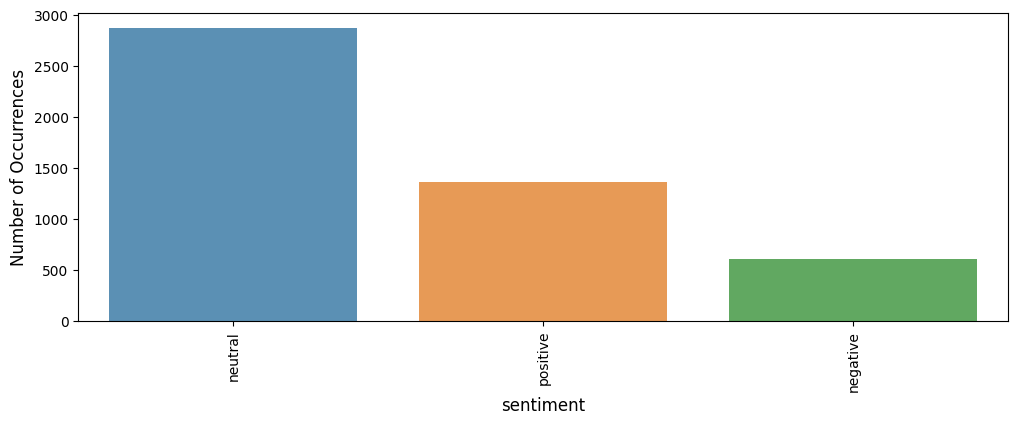

In [ ]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x = cnt_pro.index, y = cnt_pro.values,alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df.sentiment = [sentiment[item] for item in df.sentiment]
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [ ]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(4)

FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
Message: 0


In [ ]:

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

df['Message'] = df['Message'].apply(cleanText)

<ipython-input-8-4bbf36fbf50f>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [ ]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

In [ ]:

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

In [ ]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)

In [ ]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))
print('Shape of data tensor:', X.shape)

Found 4845 unique tokens.
Shape of data tensor: (4845, 50)


In [ ]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4844/4844 [00:00<00:00, 818945.08it/s]


The model is trained for 30 epochs using a loop.
In each epoch, the training data is shuffled and fed to the model for training. The learning rate (alpha) is adjusted after each epoch.

In [ ]:
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 775643.60it/s]


In [ ]:
print(d2v_model)

Doc2Vec<dm/m,d100,n5,w8,s0.001>


In [ ]:
len(d2v_model.wv.key_to_index)

11682

An embedding matrix is created to store the vectors learned by the Doc2Vec model.
np.zeros((len(d2v_model.wv.vocab) + 1, 20)): Initializes the matrix with zeros, and the shape is determined by the vocabulary size and vector dimensionality.
The for loop iterates over the indices and vectors in d2v_model.docvecs.vectors_docs.
The vectors are stored in the embedding_matrix.


In [ ]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 100))

for i, vec in enumerate(d2v_model.dv.vectors):
    while i in vec <= 1000:
      #print(i)
      #print(model.docvecs)
      embedding_matrix[i]=vec
      #print(vec)
      #print(vec[i])

find the top 10 words that are most similar to the word 'profit'.

In [ ]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.7124226093292236),
 ('profits', 0.5409313440322876),
 ('bill', 0.5199342370033264),
 ('chopra', 0.4914618134498596),
 ('larger-than-epected', 0.49099430441856384),
 ('koduetra', 0.48731207847595215),
 ('trojan', 0.4851319491863251),
 ('consolidated', 0.4775449335575104),
 ('eur61m', 0.46578648686408997),
 ('franc', 0.4542568027973175)]

In [ ]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('property', 0.5224835276603699),
 ('fund', 0.45600026845932007),
 ('ii', 0.45399677753448486),
 ('wrt1v', 0.45348650217056274),
 ('properties', 0.45220014452934265),
 ('fair', 0.44302481412887573),
 ('zao', 0.44135865569114685),
 ('ebit', 0.44007667899131775),
 ('129.9', 0.4308113157749176),
 ('gone', 0.42555269598960876)]

In [ ]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9714166522026062),
 ('kelly', 0.7240713834762573),
 ('frank', 0.7222797274589539),
 ('aptly', 0.7062240242958069),
 ('remarked', 0.7050275802612305),
 ('buys', 0.6982609629631042),
 ('tuomo', 0.6970206499099731),
 ('143.9', 0.6969266533851624),
 ('mammila', 0.6952583193778992),
 ('enp', 0.6883769035339355)]

This code defines a function called tsne_plot that takes a Word2Vec model as input and creates a t-SNE (t-distributed stochastic neighbor embedding) plot to visualize the word embeddings in a 2D space. This function first extracts the word vectors and labels from the Word2Vec model, then applies t-SNE to reduce the dimensionality of the word vectors to 2D. Finally, it plots the words in the 2D space, labeling each point with its corresponding word. The purpose of this visualization is to provide a qualitative understanding of the relationships between words in the embedding space. Words that are semantically similar should be close to each other in the plot.

In [ ]:

%matplotlib inline

def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv[word])
        labels.append(word)
    tokens = np.array(tokens)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 136 (\x88) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 139 (\x8b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


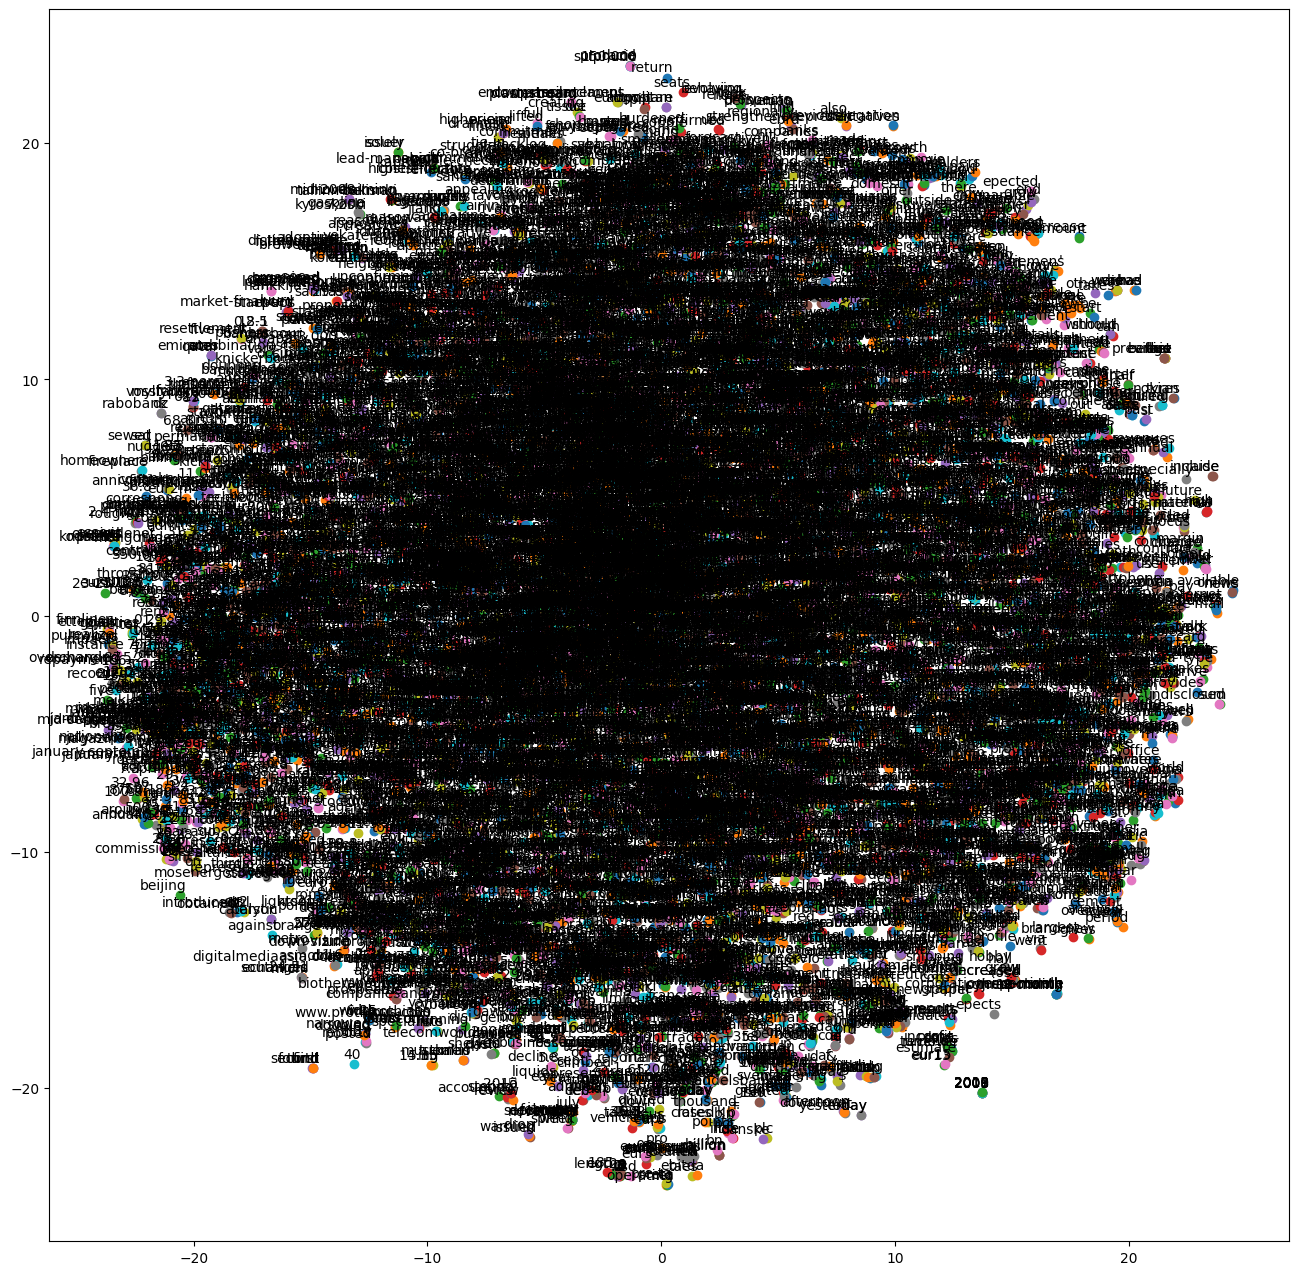

In [ ]:
tsne_plot(d2v_model)

Calculates the vocabulary size for the embedding layer. It adds 1 to the length of the vocabulary index_to_key because the indices in Keras are expected to start from 0.
Initializes a sequential model, which is a linear stack of layers.
The Embedding layer is used to map integer indices representing words to dense vectors of fixed size. The input_dim parameter is set to the vocabulary size, output_dim is the dimensionality of the embeddings (20 in this case), input_length is the length of input sequences (assumed to be the length of X), and weights is initialized with pre-trained word vectors (embedding_matrix). The embeddings are trainable (trainable=True), so they can be updated during training. Then adds an LSTM (Long Short-Term Memory) layer with 50 units to the model. return_sequences=False means that the LSTM layer only returns the output for the last timestep, not the full sequence. This adds a Dense layer with 3 units and a softmax activation function. This layer is responsible for the classification output. The choice of 3 units suggests that the model is designed for a classification task with three classes.

In [ ]:
vocab_size = len(d2v_model.wv.index_to_key) + 1

# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# learn the correlations
def split_input(sequence):
    return sequence[:-1], tf.reshape(sequence[1:], (-1, 1))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(3, activation="softmax"))

model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 100)           1168300   
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_9 (Dense)             (None, 3)                 153       
                                                                 
Total params: 1198653 (4.57 MB)
Trainable params: 1198653 (4.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


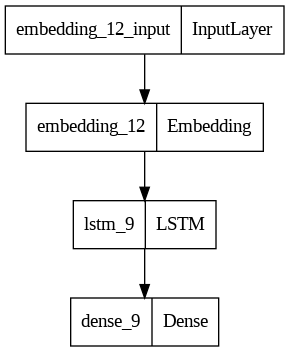

In [ ]:
plot_model(model, to_file='model.png')

In [ ]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [ ]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 10s - loss: 0.5182 - acc: 0.6234 - 10s/epoch - 75ms/step
Epoch 2/50
129/129 - 5s - loss: 0.3465 - acc: 0.7574 - 5s/epoch - 40ms/step
Epoch 3/50
129/129 - 7s - loss: 0.1998 - acc: 0.8842 - 7s/epoch - 53ms/step
Epoch 4/50
129/129 - 6s - loss: 0.1025 - acc: 0.9495 - 6s/epoch - 44ms/step
Epoch 5/50
129/129 - 5s - loss: 0.0746 - acc: 0.9679 - 5s/epoch - 40ms/step
Epoch 6/50
129/129 - 7s - loss: 0.0576 - acc: 0.9743 - 7s/epoch - 56ms/step
Epoch 7/50
129/129 - 5s - loss: 0.0385 - acc: 0.9854 - 5s/epoch - 40ms/step
Epoch 8/50
129/129 - 6s - loss: 0.0230 - acc: 0.9920 - 6s/epoch - 48ms/step
Epoch 9/50
129/129 - 6s - loss: 0.0261 - acc: 0.9893 - 6s/epoch - 49ms/step
Epoch 10/50
129/129 - 5s - loss: 0.0286 - acc: 0.9888 - 5s/epoch - 39ms/step
Epoch 11/50
129/129 - 7s - loss: 0.0278 - acc: 0.9896 - 7s/epoch - 57ms/step
Epoch 12/50
129/129 - 5s - loss: 0.0207 - acc: 0.9917 - 5s/epoch - 40ms/step
Epoch 13/50
129/129 - 6s - loss: 0.0141 - acc: 0.9947 - 6s/epoch - 43ms/step
Epoch 

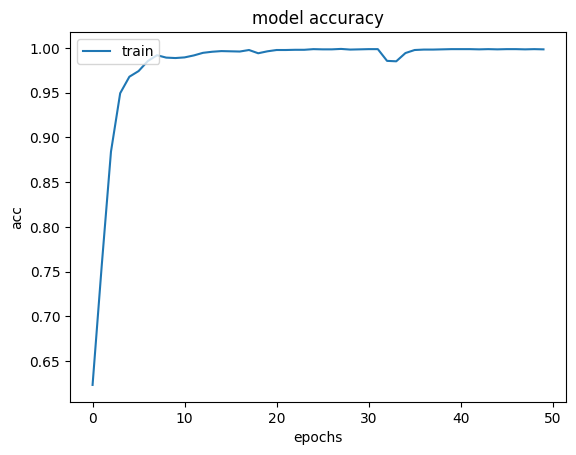

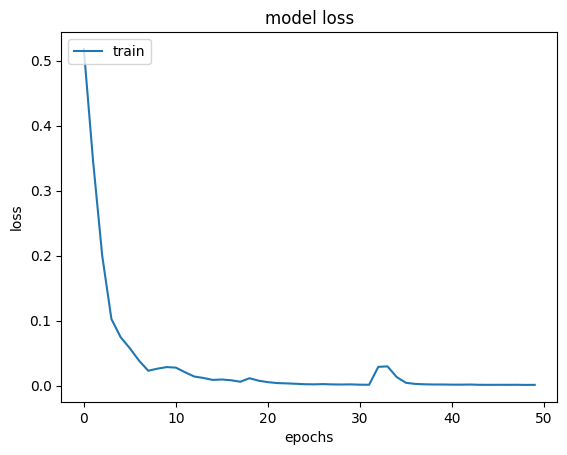

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 0.0010 - acc: 0.9993 - 1s/epoch - 11ms/step
23/23 - 0s - loss: 1.4109 - acc: 0.7139 - 189ms/epoch - 8ms/step
Train: 0.999, Test: 0.7139


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[3.8081903e-06 9.9999613e-01 2.6225104e-08]
 [9.9999994e-01 1.0774530e-08 8.4230098e-09]
 [1.7797669e-08 9.9999994e-01 1.9655888e-09]
 ...
 [1.7393403e-02 1.7275205e-03 9.8087907e-01]
 [1.4186335e-01 8.5746664e-01 6.7002804e-04]
 [1.0000000e+00 3.9816886e-08 1.4416650e-08]]
[1 0 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 2 1 1 1 2 1 0 2
 0 1 1 0 1 2 1 0 1 1 1 0 1 2 1 0 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1
 0 1 1 1 1 0 1 2 0 1 0 0 1 0 1 0 0 1 1 2 1 1 0 1 1 1 2 1 1 2 0 1 1 1 2 1 1
 1 0 0 1 0 0 0 2 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 2 1 1 1 1 1 1 0 1 0 2 1
 2 1 0 0 1 1 0 0 1 1 2 2 0 1 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 1 0 0 1 1
 2 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 2 0 1 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 2 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 0 1 0 1 2 2 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 2 0 1 2 1
 1 1 0 1 0 1 1 1 1 2 1 0 1 0 1 2 0 2 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 1 0 0 1 0 1 1 0 0 1 0 1 2 1 0 1 1 0 1 0 1 1 1 0 

In [ ]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [ ]:

cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[144,  67,   4],
       [ 81, 329,  16],
       [ 13,  27,  46]])

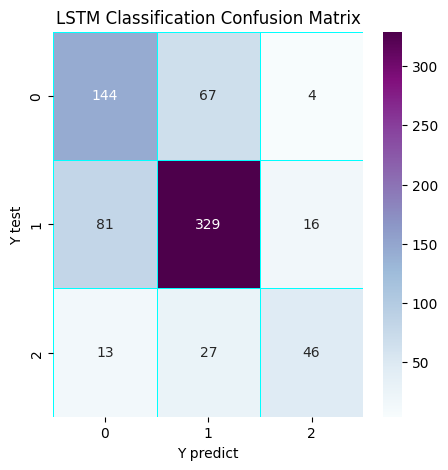

In [ ]:

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [ ]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 9ms/step - loss: 1.4619 - acc: 0.7607
score: 1.46
acc: 0.76


In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])


1/1 [==============================] - 0s 24ms/step
[[1.2825432e-02 5.2662607e-04 9.8664790e-01]] 2


In [ ]:
message = ['Unfortunately you have lost $1,000']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])


1/1 [==============================] - 0s 36ms/step
[[5.1316395e-08 7.1829753e-08 9.9999988e-01]] 2


In [ ]:
message = ['You have an exam']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])


1/1 [==============================] - 0s 22ms/step
[[0.01393998 0.9286782  0.05738185]] 1


In [ ]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])


1/1 [==============================] - 0s 36ms/step
[[4.3078867e-06 7.6726692e-06 9.9998796e-01]] 2


In [ ]:
message = ['You lost the competition']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])


1/1 [==============================] - 0s 24ms/step
[[0.00340975 0.09440696 0.90218323]] 2


In [ ]:
message = ['Today the weather is good']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 24ms/step
[[9.9038029e-01 8.7102689e-03 9.0944866e-04]] 0
